# OncoGrid plot
The aim of this visualisation is to evaluate whether mutations in miR-361-3p-dysregulated genes could be used as sensitivity biomarkers to Olaparib (PARP inhibitor).

The data used here includes: 
* Mutation data of cell lines in DepMap (CCLE): https://depmap.org/portal/download/all/?releasename=DepMap+Public+23Q2&filename=OmicsSomaticMutations.csv
* Olaparib IC50s from the PRISM study: https://depmap.org/portal/download/all/?releasename=PRISM+Repurposing+19Q4&filename=secondary-screen-dose-response-curve-parameters.csv

There are multiple types of mutations in the CCLE. These are namely:
* 'SILENT': synonymous mutation
* 'MISSENSE': change that results in different aa, some may alter the function of the resulting protein.
* 'FRAME_SHIFT_DEL': mutation due to deletion of N bases that is not divisible by three, thus can change the reading frame.
* 'SPLICE_SITE': mutation that inserts, deletes or changes a number of nt in the specific site at which splicing takes place.
* 'NONSENSE': (stop gain) change that causes a protein to terminate or end its translation earlier than expected.
* 'NONSTOP': (stop loss) mutations convert a stop into a sense codon 
* 'FRAME_SHIFT_INS': mutation due to insertion of a number of nt that is not divisible by three, thus can change the reading frame. 

To understand the consequence and impact of these mutations, the https://www.ensembl.org/info/docs/tools/vep/index.html can be used.

### Load libraries

In [38]:
import pandas as pd
import numpy as np

# Import custom functions
import oncogrid_utils

### Load data

In [ ]:
#Import data
mutation_data = pd.read_csv('OmicsSomaticMutations.csv')

#Import PRISM data
prism_data = pd.read_csv('secondary-screen-dose-response-curve-parameters.csv')

In [40]:
# Upload a group of genes of interest (e.g. miR-361-3p signature genes)
miR361_signature = pd.read_csv('tt_table_GR_EdgeR.txt', sep=',', index_col= 'Unnamed: 0')

miR361_signature = tuple(miR361_signature[(miR361_signature.FDR < 0.05) & 
                                          (miR361_signature.logFC > 1)].symbol.dropna())


miR361_signature = [gene for gene in miR361_signature if gene in mutation_data['HugoSymbol'].unique()]

### Format data

In [44]:
# Subset ic50 data for drug of interest (e.g. Olaparib)
drug = 'olaparib'

ic50_data = prism_data[prism_data.name == drug]

# Remove cell lines with missing IC50, or depmapID
ic50_data = ic50_data[~ic50_data.ic50.isna()]
ic50_data = ic50_data[~ic50_data.depmap_id.isna()]

# Keep cell lines with mutation data
# Assuming all cell lines will have at least 1 mutation - these are the cell lines screened for mutations
cells_with_mutation = mutation_data['ModelID'].unique()
ic50_data = ic50_data[ic50_data.depmap_id.isin(cells_with_mutation)]

# If there are duplicate secreens, keep the screen_id = HTS002
ic50_data = ic50_data.sort_values(by = 'screen_id', ascending= True).drop_duplicates(subset=['depmap_id', 'name'], keep='first')

ic50_data.head()

,broad_id,depmap_id,ccle_name,screen_id,upper_limit,lower_limit,slope,r2,auc,ec50,ic50,name,moa,target,disease.area,indication,smiles,phase,passed_str_profiling,row_name
54341,BRD-K02113016-001-15-4,ACH-000879,MFE296_ENDOMETRIUM,HTS002,1,0.081803,2.915433,0.387995,0.951242,6.512018,6.923549,olaparib,PARP inhibitor,"PARP1, PARP2",oncology,ovarian cancer,Fc1ccc(Cc2n[nH]c(=O)c3ccccc23)cc1C(=O)N1CCN(CC...,Launched,True,ACH-000879
54667,BRD-K02113016-001-15-4,ACH-000776,ONS76_CENTRAL_NERVOUS_SYSTEM,HTS002,1,0.373603,5.435709,0.320941,0.943091,4.147395,5.341311,olaparib,PARP inhibitor,"PARP1, PARP2",oncology,ovarian cancer,Fc1ccc(Cc2n[nH]c(=O)c3ccccc23)cc1C(=O)N1CCN(CC...,Launched,True,ACH-000776
54666,BRD-K02113016-001-15-4,ACH-000862,KMBC2_URINARY_TRACT,HTS002,1,0.369692,2.791243,0.331078,0.909618,2.505596,4.056361,olaparib,PARP inhibitor,"PARP1, PARP2",oncology,ovarian cancer,Fc1ccc(Cc2n[nH]c(=O)c3ccccc23)cc1C(=O)N1CCN(CC...,Launched,True,ACH-000862
54665,BRD-K02113016-001-15-4,ACH-000389,H4_CENTRAL_NERVOUS_SYSTEM,HTS002,1,-0.039503,1.203222,0.305187,0.845275,2.586139,2.427760,olaparib,PARP inhibitor,"PARP1, PARP2",oncology,ovarian cancer,Fc1ccc(Cc2n[nH]c(=O)c3ccccc23)cc1C(=O)N1CCN(CC...,Launched,True,ACH-000389
54659,BRD-K02113016-001-15-4,ACH-000750,LOXIMVI_SKIN,HTS002,1,0.190041,1.665380,-0.020750,0.866966,2.122313,2.828169,olaparib,PARP inhibitor,"PARP1, PARP2",oncology,ovarian cancer,Fc1ccc(Cc2n[nH]c(=O)c3ccccc23)cc1C(=O)N1CCN(CC...,Launched,True,ACH-000750


In [45]:
# Some samples may have multiple mutations in the same gene - keeping only the most impactful
mutations_df = oncogrid_utils.convert_mutations_impact(mutation_data,
                                                       index = ['ModelID', 
                                                                'HugoSymbol']).rename(columns = {'ModelID': 'depmap_id'})

# Subset mutations in genes of interest and join it with ic50 table
mutations_df = mutations_df[mutations_df['HugoSymbol'].isin(miR361_signature)].set_index(['depmap_id', 'HugoSymbol'])

# Fill mmissing combos
mutations_df = mutations_df.reindex(pd.MultiIndex.from_product([ic50_data.depmap_id.unique(), 
                                                                          miR361_signature],
                                                                          names=['depmap_id', 'HugoSymbol']), 
                                            fill_value= 'not_mutated').reset_index()

# Merge mutation and ic50 data
mutations_ic50_df = ic50_data.merge(mutations_df, on = 'depmap_id', how = 'left') 

#Check if we have lost any cell lines:
set(ic50_data.depmap_id) - set(mutations_ic50_df.depmap_id)


mutations_ic50_df.head()

,broad_id,depmap_id,ccle_name,screen_id,upper_limit,lower_limit,slope,r2,auc,ec50,ic50,name,moa,target,disease.area,indication,smiles,phase,passed_str_profiling,row_name,HugoSymbol,Chrom,Pos,Ref,Alt,AF,RefCount,AltCount,GT,PS,VariantType,VariantInfo,DNAChange,ProteinChange,HgncName,HgncFamily,Transcript,TranscriptExon,TranscriptStrand,UniprotID,Str,DbsnpID,DbsnpFilter,Issues,GcContent,LineageAssociation,CancerMolecularGenetics,CCLEDeleterious,StructuralRelation,CosmicHotspot,CosmicOverlappingMutations,AssociatedWith,LoF,Driver,LikelyDriver,TranscriptLikelyLoF,CivicID,CivicDescription,CivicScore,Popaf,LikelyGoF,LikelyLoF,HessDriver,HessSignature,CscapeScore,DannScore,RevelScore,Funseq2Score,PharmgkbID,DidaID,DidaName,GwasDisease,GwasPmID,GTexGene,EntrezGeneID,mutation_impact_score
0,BRD-K02113016-001-15-4,ACH-000879,MFE296_ENDOMETRIUM,HTS002,1,0.081803,2.915433,0.387995,0.951242,6.512018,6.923549,olaparib,PARP inhibitor,"PARP1, PARP2",oncology,ovarian cancer,Fc1ccc(Cc2n[nH]c(=O)c3ccccc23)cc1C(=O)N1CCN(CC...,Launched,True,ACH-000879,IGFBP5,not_mutated,not_mutated,not_mutated,not_mutated,not_mutated,not_mutated,not_mutated,not_mutated,not_mutated,not_mutated,not_mutated,not_mutated,not_mutated,not_mutated,not_mutated,not_mutated,not_mutated,not_mutated,not_mutated,not_mutated,not_mutated,not_mutated,not_mutated,not_mutated,not_mutated,not_mutated,not_mutated,not_mutated,not_mutated,not_mutated,not_mutated,not_mutated,not_mutated,not_mutated,not_mutated,not_mutated,not_mutated,not_mutated,not_mutated,not_mutated,not_mutated,not_mutated,not_mutated,not_mutated,not_mutated,not_mutated,not_mutated,not_mutated,not_mutated,not_mutated,not_mutated,not_mutated,not_mutated,not_mutated,not_mutated
1,BRD-K02113016-001-15-4,ACH-000879,MFE296_ENDOMETRIUM,HTS002,1,0.081803,2.915433,0.387995,0.951242,6.512018,6.923549,olaparib,PARP inhibitor,"PARP1, PARP2",oncology,ovarian cancer,Fc1ccc(Cc2n[nH]c(=O)c3ccccc23)cc1C(=O)N1CCN(CC...,Launched,True,ACH-000879,AZGP1,not_mutated,not_mutated,not_mutated,not_mutated,not_mutated,not_mutated,not_mutated,not_mutated,not_mutated,not_mutated,not_mutated,not_mutated,not_mutated,not_mutated,not_mutated,not_mutated,not_mutated,not_mutated,not_mutated,not_mutated,not_mutated,not_mutated,not_mutated,not_mutated,not_mutated,not_mutated,not_mutated,not_mutated,not_mutated,not_mutated,not_mutated,not_mutated,not_mutated,not_mutated,not_mutated,not_mutated,not_mutated,not_mutated,not_mutated,not_mutated,not_mutated,not_mutated,not_mutated,not_mutated,not_mutated,not_mutated,not_mutated,not_mutated,not_mutated,not_mutated,not_mutated,not_mutated,not_mutated,not_mutated,not_mutated
2,BRD-K02113016-001-15-4,ACH-000879,MFE296_ENDOMETRIUM,HTS002,1,0.081803,2.915433,0.387995,0.951242,6.512018,6.923549,olaparib,PARP inhibitor,"PARP1, PARP2",oncology,ovarian cancer,Fc1ccc(Cc2n[nH]c(=O)c3ccccc23)cc1C(=O)N1CCN(CC...,Launched,True,ACH-000879,ACP5,not_mutated,not_mutated,not_mutated,not_mutated,not_mutated,not_mutated,not_mutated,not_mutated,not_mutated,not_mutated,not_mutated,not_mutated,not_mutated,not_mutated,not_mutated,not_mutated,not_mutated,not_mutated,not_mutated,not_mutated,not_mutated,not_mutated,not_mutated,not_mutated,not_mutated,not_mutated,not_mutated,not_mutated,not_mutated,not_mutated,not_mutated,not_mutated,not_mutated,not_mutated,not_mutated,not_mutated,not_mutated,not_mutated,not_mutated,not_mutated,not_mutated,not_mutated,not_mutated,not_mutated,not_mutated,not_mutated,not_mutated,not_mutated,not_mutated,not_mutated,not_mutated,not_mutated,not_mutated,not_mutated,not_mutated
3,BRD-K02113016-001-15-4,ACH-000879,MFE296_ENDOMETRIUM,HTS002,1,0.081803,2.915433,0.387995,0.951242,6.512018,6.923549,olaparib,PARP inhibitor,"PARP1, PARP2",oncology,ovarian cancer,Fc1ccc(Cc2n[nH]c(=O)c3ccccc23)cc1C(=O)N1CCN(CC...,Launched,True,ACH-000879,UGT2B15,not_mutated,not_mutated,not_mutated,not_mutated,not_mutated,not_mutated,not_mutated,not_mutated,not_mutated,not_mutated,not_mutated,not_mutated,not_mutated,not_mutated,not_mutated

#### Compute statistics 
Does the mutation status in genes of tthe miR-361-3p signature separate cell lines with significantly different Olaparib IC50?

Note: stastistics are not computed for a gene-tissue combination if there are fewer than 'n_min' cell lines in either mutation group, this threshold defaults to 3.0. The split_by argument is used to set the split between cell lines (e.g. cell lines with high/medium mutations in gene X vs cell lines with low/non-mutated gene X).

In [15]:
mannwhitneyu_output, mutations_table = oncogrid_utils.compute_mannwhitney_stats(mutations_ic50_df, 
                                                                                split_by = 'HigMed_v_ModLowNon', 
                                                                                n_min = 3.0)
mannwhitneyu_output.head()

,gene_name,tissue,n_cell_mut,mean_mutated,n_cell_NOTmut,mean_NOTmutated,mannwhitneyu_statistic,p_value
0,CRAT,ovarian cancer,3,3.812135,134,4.046055,193.0,0.917385


#### Visualise mutation association with IC50s with onco-grid plot

Generate an oncogrid-type of plot, which includestwo subplots: 
* (1) A barplot at the top with the IC50 values for each cell line (x-axis). Columns are color coded by respective indication of the cell line (in this case Olaparib was only screened in ovarian cancer) 
* (2) A heatmap at the bottom with gene mutations (y-axis) for each cell line (x-axis). Mutations are color coded by mutation impact (High, Moderate, Modifier, Low or Not mutated) as per https://www.ensembl.org/info/docs/tools/vep/index.html

Note: when multiple mutations in the same gene in the same cell line are found, the most toxic/impactful will be kept and displayed

In [33]:
sort_yaxis = 'mutation_count'
plot_title = 'Olaparib and mutations in miR-361-3p signature genes'
mutation_column = 'mutation_impact_score'
figsize=(20, 20)
label_fontsize=10
ticklabels_fontsize=12
legend_fontsize = 12

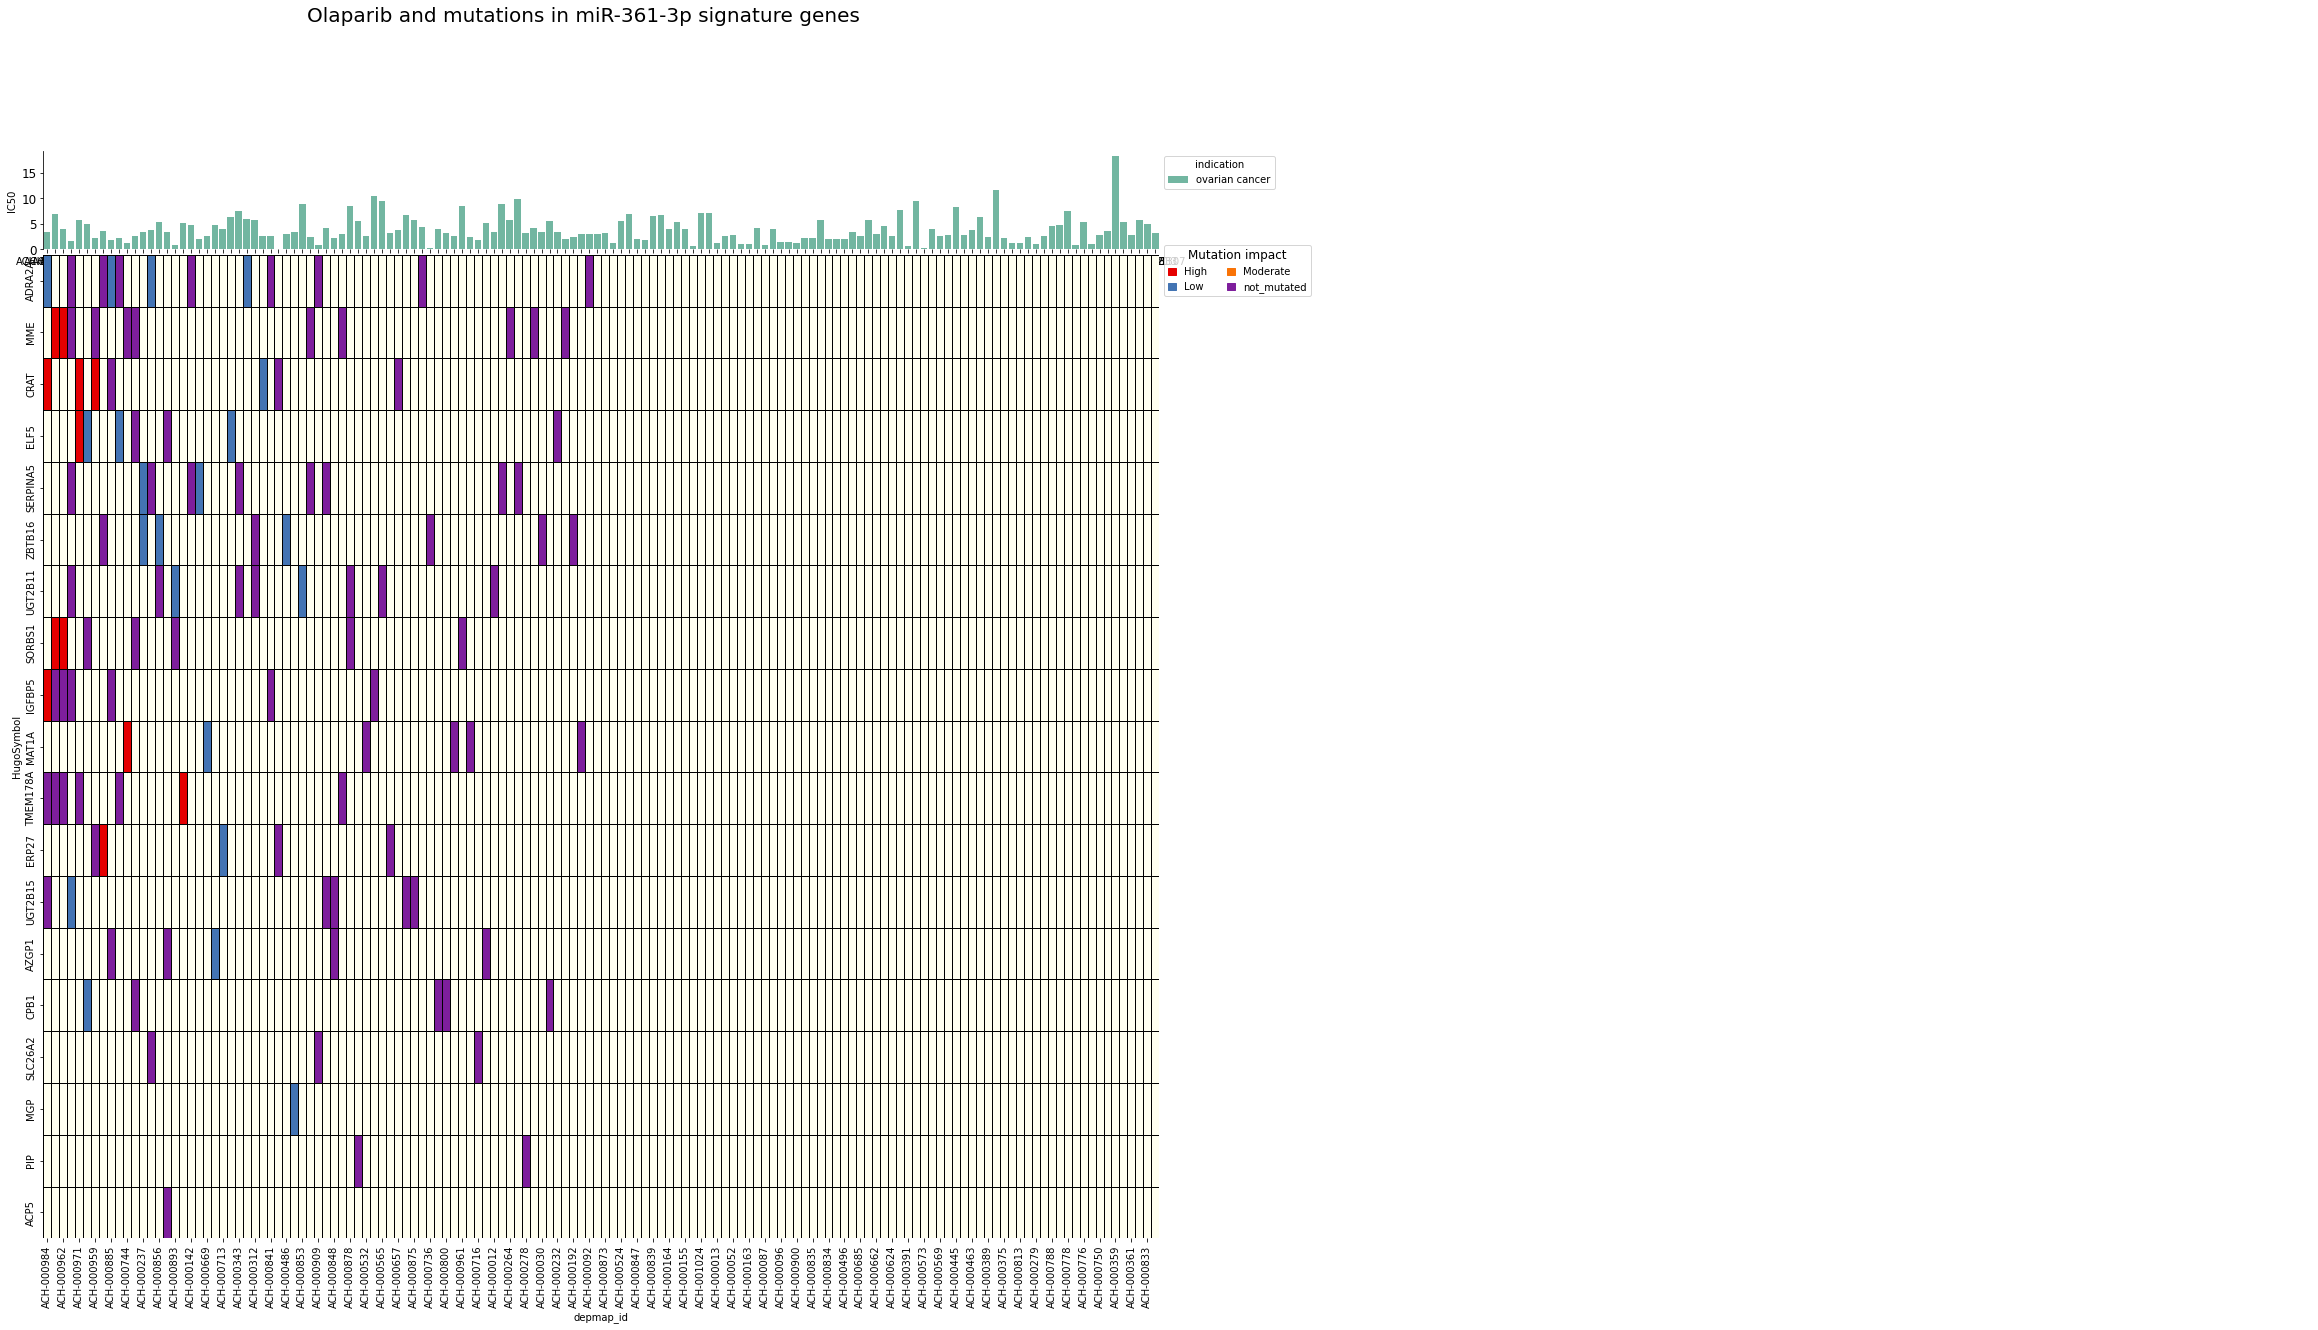

In [46]:
mut_table, ic50_df, value_to_int = oncogrid_utils.format_df_oncogrid(mutations_ic50_df, sort_yaxis, 
                                                                     mutation_column)
plot = oncogrid_utils.plot_oncogrid_ic50(mut_table, ic50_df, figsize, plot_title, 
                                         label_fontsize, ticklabels_fontsize, legend_fontsize, value_to_int)